# Import Dataset

In the cell below we import the Retinal OCT IMages dataset.We populate few varaibles using the load_files function from the scikit-learn library:


1. train_files, valid_files, test_files - numpy arrays containing file paths to images
2. train_targets, valid_targets, test_targets - numpy arrays containing onehot-encoded classification labels
3. condition_names - list of string valued condition name for translating the labels

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

#define function to load train,test and validation datasets

def load_datasets(path):
    data =load_files(path)
    oct_files = np.array(data['filenames'])
    oct_targets = np_utils.to_categorical(np.array(data['target']), 4)
    
    return oct_files,oct_targets

#load train,test and validation datsets

train_files,train_targets = load_datasets('C:/Users/Administrator/Documents/RetinalOCT/data/train/')
valid_files,valid_targets = load_datasets('C:/Users/Administrator/Documents/RetinalOCT/data/val')
test_files,test_targets = load_datasets('C:/Users/Administrator/Documents/RetinalOCT/data/test')

# list of condition names
condition_names = [item[10:-1] for item in sorted(glob('C:/Users/Administrator/Documents/RetinalOCT/data/train/*/'))]

#print the statistics about the datset
print('There are {} total diffrent conditions'.format(len(condition_names)))
print('There are %s total images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training  images.' % len(train_files))
print('There are %d validation images.' % len(valid_files))
print('There are %d test images.'% len(test_files))

Using TensorFlow backend.


There are 4 total diffrent conditions
There are 84484 total images.

There are 83484 training  images.
There are 32 validation images.
There are 968 test images.


#  Pre-Process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape
(nb_samples, rows, columns, channels),
where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

The path_to_tensor function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is  pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

(1,150,150,3)

The paths_to_tensor function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape (nb_samples,150,150,3).

Here, nb_samples is the number of samples, or number of images, in the supplied array of image paths. It is best to think of nb_samples as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(150, 150))
    # convert PIL.Image.Image type to 3D tensor with shape (150, 150, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 150, 150, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

We rescale the images by dividing every pixel in every image by 255.

In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 968/968 [00:06<00:00, 149.41it/s]


# Image Augmentation

In [4]:
from keras.preprocessing import image


train_datagen = image.ImageDataGenerator(zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = image.ImageDataGenerator()

train_generator = train_datagen.flow(train_tensors,train_targets, batch_size=30)

val_generator = val_datagen.flow(valid_tensors,valid_targets, batch_size=20)

# View the Train Dataset Images

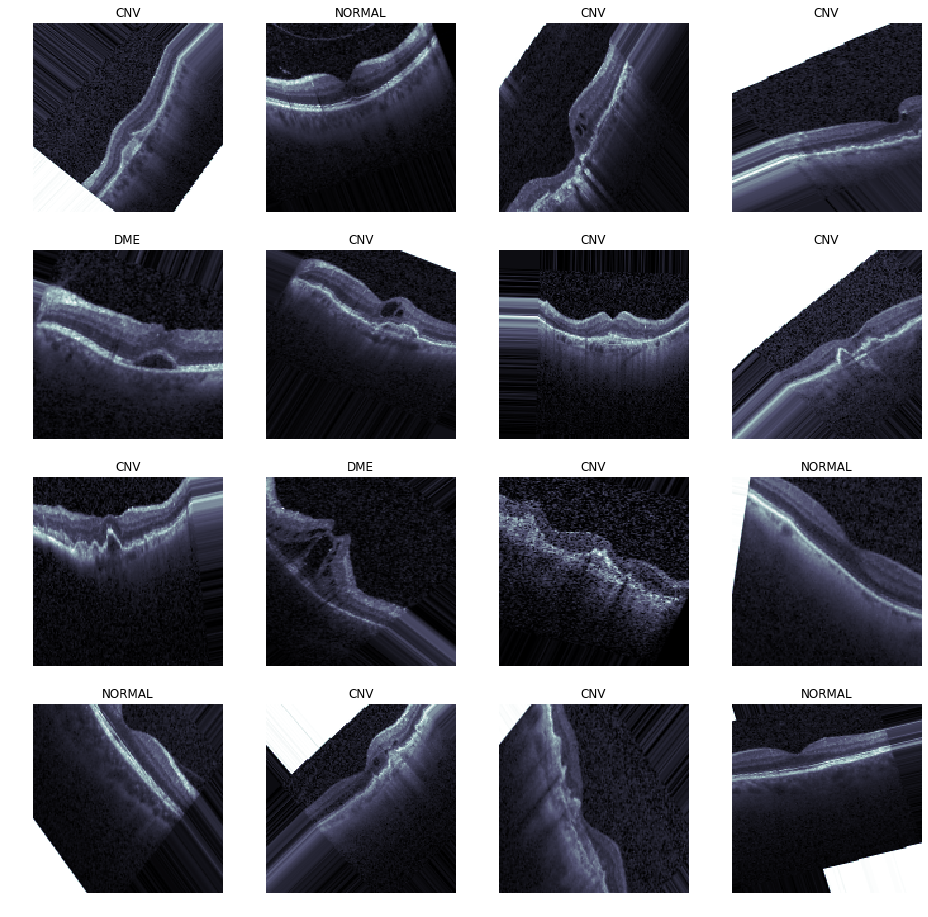

In [10]:
#View the dataset Images

import matplotlib.pyplot as plt

t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title(', '.join([condition_names[45:] for condition_names, n_score in zip(condition_names, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Basic CNN

Here we implment a CNN with 3 convolution layers wiht filter sizes 16,32,64 of kernel size 2, batch normalization using activation function'elu' then we use a fully connected layer to predict the 4 Class labels using the softmax as activation function.

In [12]:
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,BatchNormalization,Activation
from keras.layers import Dropout,Flatten,Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters =16, kernel_size=2,kernel_initializer='he_normal',padding='same',input_shape=(150,150,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(4))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 150, 150, 16)      208       
_________________________________________________________________
batch_normalization_9 (Batch (None, 150, 150, 16)      64        
_________________________________________________________________
activation_9 (Activation)    (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 32)        2080      
_________________________________________________________________
batch_normalization_10 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
activation_10 (Activation)   (None, 75, 75, 32)        0         
__________

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
from keras.callbacks import ModelCheckpoint  

epochs = 4

checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch.hdf5',verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),epochs=epochs, batch_size=100, callbacks=[checkpointer], verbose=1)

Train on 83484 samples, validate on 32 samples
Epoch 1/4


20300/83484 [======>.......................] - ETA: 31:13 - loss: 1.0238 - acc: 0.63 - ETA: 30:53 - loss: 1.0829 - acc: 0.62 - ETA: 30:49 - loss: 1.0754 - acc: 0.61 - ETA: 30:49 - loss: 1.0737 - acc: 0.61 - ETA: 30:56 - loss: 1.0763 - acc: 0.61 - ETA: 30:55 - loss: 1.0914 - acc: 0.59 - ETA: 30:58 - loss: 1.0949 - acc: 0.59 - ETA: 30:55 - loss: 1.1160 - acc: 0.58 - ETA: 30:49 - loss: 1.1089 - acc: 0.59 - ETA: 30:47 - loss: 1.1078 - acc: 0.58 - ETA: 30:49 - loss: 1.1019 - acc: 0.59 - ETA: 30:44 - loss: 1.1131 - acc: 0.58 - ETA: 30:43 - loss: 1.1087 - acc: 0.58 - ETA: 30:45 - loss: 1.1015 - acc: 0.58 - ETA: 30:41 - loss: 1.1015 - acc: 0.58 - ETA: 30:39 - loss: 1.1069 - acc: 0.58 - ETA: 30:36 - loss: 1.1045 - acc: 0.58 - ETA: 30:35 - loss: 1.0998 - acc: 0.59 - ETA: 30:32 - loss: 1.1005 - acc: 0.59 - ETA: 30:34 - loss: 1.1018 - acc: 0.59 - ETA: 30:34 - loss: 1.1063 - acc: 0.58 - ETA: 30:31 - loss: 1.1052 - acc: 0.58 - ETA: 30:27 - loss: 1.1070 - acc: 0.58 - ETA: 30:27 - loss: 1.1126 - acc: 

81500/83484 [============================>.] - ETA: 8:21 - loss: 0.9164 - acc: 0.669 - ETA: 8:19 - loss: 0.9161 - acc: 0.669 - ETA: 8:17 - loss: 0.9160 - acc: 0.669 - ETA: 8:14 - loss: 0.9160 - acc: 0.669 - ETA: 8:12 - loss: 0.9158 - acc: 0.669 - ETA: 8:10 - loss: 0.9156 - acc: 0.670 - ETA: 8:08 - loss: 0.9154 - acc: 0.670 - ETA: 8:05 - loss: 0.9150 - acc: 0.670 - ETA: 8:03 - loss: 0.9152 - acc: 0.670 - ETA: 8:01 - loss: 0.9149 - acc: 0.670 - ETA: 7:59 - loss: 0.9147 - acc: 0.670 - ETA: 7:56 - loss: 0.9144 - acc: 0.670 - ETA: 7:54 - loss: 0.9142 - acc: 0.670 - ETA: 7:52 - loss: 0.9141 - acc: 0.670 - ETA: 7:50 - loss: 0.9139 - acc: 0.670 - ETA: 7:47 - loss: 0.9138 - acc: 0.670 - ETA: 7:45 - loss: 0.9137 - acc: 0.670 - ETA: 7:43 - loss: 0.9134 - acc: 0.670 - ETA: 7:41 - loss: 0.9132 - acc: 0.670 - ETA: 7:38 - loss: 0.9133 - acc: 0.670 - ETA: 7:36 - loss: 0.9132 - acc: 0.670 - ETA: 7:34 - loss: 0.9130 - acc: 0.670 - ETA: 7:31 - loss: 0.9131 - acc: 0.670 - ETA: 7:29 - loss: 0.9130 - acc: 0

83484/83484 [==============================] - ETA: 42s - loss: 0.8820 - acc: 0.68 - ETA: 40s - loss: 0.8818 - acc: 0.68 - ETA: 37s - loss: 0.8814 - acc: 0.68 - ETA: 35s - loss: 0.8813 - acc: 0.68 - ETA: 33s - loss: 0.8810 - acc: 0.68 - ETA: 31s - loss: 0.8811 - acc: 0.68 - ETA: 28s - loss: 0.8808 - acc: 0.68 - ETA: 26s - loss: 0.8806 - acc: 0.68 - ETA: 24s - loss: 0.8806 - acc: 0.68 - ETA: 22s - loss: 0.8806 - acc: 0.68 - ETA: 19s - loss: 0.8804 - acc: 0.68 - ETA: 17s - loss: 0.8803 - acc: 0.68 - ETA: 15s - loss: 0.8801 - acc: 0.68 - ETA: 13s - loss: 0.8800 - acc: 0.68 - ETA: 10s - loss: 0.8800 - acc: 0.68 - ETA: 8s - loss: 0.8797 - acc: 0.6816 - ETA: 6s - loss: 0.8796 - acc: 0.681 - ETA: 4s - loss: 0.8793 - acc: 0.681 - ETA: 1s - loss: 0.8791 - acc: 0.681 - 1880s 23ms/step - loss: 0.8789 - acc: 0.6818 - val_loss: 1.0798 - val_acc: 0.5312

Epoch 00001: val_loss improved from inf to 1.07976, saving model to weights.best.from_scratch.hdf5
Epoch 2/4


20400/83484 [======>.......................] - ETA: 31:29 - loss: 0.8994 - acc: 0.68 - ETA: 31:33 - loss: 0.8264 - acc: 0.67 - ETA: 31:15 - loss: 0.8583 - acc: 0.65 - ETA: 31:15 - loss: 0.8049 - acc: 0.68 - ETA: 31:07 - loss: 0.8313 - acc: 0.68 - ETA: 31:09 - loss: 0.8182 - acc: 0.68 - ETA: 31:10 - loss: 0.7958 - acc: 0.69 - ETA: 31:01 - loss: 0.7948 - acc: 0.70 - ETA: 30:56 - loss: 0.7752 - acc: 0.71 - ETA: 30:54 - loss: 0.7878 - acc: 0.70 - ETA: 30:57 - loss: 0.7726 - acc: 0.71 - ETA: 30:56 - loss: 0.7824 - acc: 0.70 - ETA: 30:52 - loss: 0.7782 - acc: 0.70 - ETA: 30:51 - loss: 0.7714 - acc: 0.70 - ETA: 30:48 - loss: 0.7678 - acc: 0.71 - ETA: 30:51 - loss: 0.7631 - acc: 0.71 - ETA: 30:48 - loss: 0.7586 - acc: 0.71 - ETA: 30:48 - loss: 0.7499 - acc: 0.72 - ETA: 30:45 - loss: 0.7499 - acc: 0.72 - ETA: 30:43 - loss: 0.7458 - acc: 0.72 - ETA: 30:40 - loss: 0.7457 - acc: 0.72 - ETA: 30:40 - loss: 0.7427 - acc: 0.72 - ETA: 30:38 - loss: 0.7432 - acc: 0.72 - ETA: 30:38 - loss: 0.7408 - acc: 

81700/83484 [============================>.] - ETA: 8:19 - loss: 0.7160 - acc: 0.736 - ETA: 8:16 - loss: 0.7158 - acc: 0.736 - ETA: 8:14 - loss: 0.7158 - acc: 0.736 - ETA: 8:12 - loss: 0.7158 - acc: 0.736 - ETA: 8:10 - loss: 0.7157 - acc: 0.736 - ETA: 8:07 - loss: 0.7155 - acc: 0.736 - ETA: 8:05 - loss: 0.7156 - acc: 0.736 - ETA: 8:03 - loss: 0.7156 - acc: 0.736 - ETA: 8:01 - loss: 0.7154 - acc: 0.736 - ETA: 7:58 - loss: 0.7153 - acc: 0.736 - ETA: 7:56 - loss: 0.7153 - acc: 0.736 - ETA: 7:54 - loss: 0.7153 - acc: 0.736 - ETA: 7:52 - loss: 0.7151 - acc: 0.736 - ETA: 7:49 - loss: 0.7152 - acc: 0.736 - ETA: 7:47 - loss: 0.7150 - acc: 0.736 - ETA: 7:45 - loss: 0.7149 - acc: 0.736 - ETA: 7:43 - loss: 0.7147 - acc: 0.737 - ETA: 7:40 - loss: 0.7145 - acc: 0.737 - ETA: 7:38 - loss: 0.7143 - acc: 0.737 - ETA: 7:36 - loss: 0.7141 - acc: 0.737 - ETA: 7:33 - loss: 0.7139 - acc: 0.737 - ETA: 7:31 - loss: 0.7138 - acc: 0.737 - ETA: 7:29 - loss: 0.7135 - acc: 0.737 - ETA: 7:27 - loss: 0.7136 - acc: 0

83484/83484 [==============================] - ETA: 37s - loss: 0.7059 - acc: 0.74 - ETA: 35s - loss: 0.7060 - acc: 0.74 - ETA: 33s - loss: 0.7061 - acc: 0.74 - ETA: 31s - loss: 0.7061 - acc: 0.74 - ETA: 28s - loss: 0.7062 - acc: 0.74 - ETA: 26s - loss: 0.7062 - acc: 0.74 - ETA: 24s - loss: 0.7063 - acc: 0.74 - ETA: 22s - loss: 0.7064 - acc: 0.74 - ETA: 19s - loss: 0.7064 - acc: 0.74 - ETA: 17s - loss: 0.7064 - acc: 0.74 - ETA: 15s - loss: 0.7063 - acc: 0.74 - ETA: 13s - loss: 0.7061 - acc: 0.74 - ETA: 10s - loss: 0.7059 - acc: 0.74 - ETA: 8s - loss: 0.7057 - acc: 0.7406 - ETA: 6s - loss: 0.7058 - acc: 0.740 - ETA: 4s - loss: 0.7057 - acc: 0.740 - ETA: 1s - loss: 0.7057 - acc: 0.740 - 1881s 23ms/step - loss: 0.7058 - acc: 0.7406 - val_loss: 1.5017 - val_acc: 0.6562

Epoch 00002: val_loss did not improve from 1.07976
Epoch 3/4


20400/83484 [======>.......................] - ETA: 31:22 - loss: 0.7485 - acc: 0.72 - ETA: 31:33 - loss: 0.7321 - acc: 0.70 - ETA: 31:22 - loss: 0.6634 - acc: 0.74 - ETA: 31:27 - loss: 0.6408 - acc: 0.75 - ETA: 31:29 - loss: 0.6637 - acc: 0.74 - ETA: 31:15 - loss: 0.6765 - acc: 0.74 - ETA: 31:09 - loss: 0.6672 - acc: 0.74 - ETA: 31:06 - loss: 0.6768 - acc: 0.73 - ETA: 31:04 - loss: 0.6736 - acc: 0.74 - ETA: 31:02 - loss: 0.6624 - acc: 0.74 - ETA: 31:04 - loss: 0.6648 - acc: 0.74 - ETA: 31:00 - loss: 0.6574 - acc: 0.74 - ETA: 30:58 - loss: 0.6570 - acc: 0.74 - ETA: 30:54 - loss: 0.6640 - acc: 0.74 - ETA: 30:53 - loss: 0.6562 - acc: 0.74 - ETA: 30:49 - loss: 0.6592 - acc: 0.74 - ETA: 30:45 - loss: 0.6595 - acc: 0.74 - ETA: 30:44 - loss: 0.6556 - acc: 0.75 - ETA: 30:42 - loss: 0.6548 - acc: 0.75 - ETA: 30:39 - loss: 0.6562 - acc: 0.75 - ETA: 30:39 - loss: 0.6670 - acc: 0.75 - ETA: 30:39 - loss: 0.6694 - acc: 0.75 - ETA: 30:36 - loss: 0.6685 - acc: 0.75 - ETA: 30:33 - loss: 0.6690 - acc: 

81700/83484 [============================>.] - ETA: 8:19 - loss: 0.6454 - acc: 0.764 - ETA: 8:17 - loss: 0.6452 - acc: 0.764 - ETA: 8:14 - loss: 0.6451 - acc: 0.764 - ETA: 8:12 - loss: 0.6448 - acc: 0.764 - ETA: 8:10 - loss: 0.6446 - acc: 0.764 - ETA: 8:08 - loss: 0.6444 - acc: 0.764 - ETA: 8:05 - loss: 0.6441 - acc: 0.764 - ETA: 8:03 - loss: 0.6440 - acc: 0.764 - ETA: 8:01 - loss: 0.6441 - acc: 0.764 - ETA: 7:59 - loss: 0.6439 - acc: 0.764 - ETA: 7:56 - loss: 0.6440 - acc: 0.764 - ETA: 7:54 - loss: 0.6440 - acc: 0.764 - ETA: 7:52 - loss: 0.6440 - acc: 0.764 - ETA: 7:50 - loss: 0.6440 - acc: 0.764 - ETA: 7:47 - loss: 0.6438 - acc: 0.765 - ETA: 7:45 - loss: 0.6438 - acc: 0.765 - ETA: 7:43 - loss: 0.6440 - acc: 0.765 - ETA: 7:41 - loss: 0.6439 - acc: 0.764 - ETA: 7:38 - loss: 0.6438 - acc: 0.765 - ETA: 7:36 - loss: 0.6438 - acc: 0.765 - ETA: 7:34 - loss: 0.6441 - acc: 0.764 - ETA: 7:32 - loss: 0.6441 - acc: 0.764 - ETA: 7:29 - loss: 0.6441 - acc: 0.764 - ETA: 7:27 - loss: 0.6440 - acc: 0

83484/83484 [==============================] - ETA: 37s - loss: 0.6397 - acc: 0.76 - ETA: 35s - loss: 0.6395 - acc: 0.76 - ETA: 33s - loss: 0.6395 - acc: 0.76 - ETA: 31s - loss: 0.6395 - acc: 0.76 - ETA: 28s - loss: 0.6395 - acc: 0.76 - ETA: 26s - loss: 0.6394 - acc: 0.76 - ETA: 24s - loss: 0.6395 - acc: 0.76 - ETA: 22s - loss: 0.6395 - acc: 0.76 - ETA: 19s - loss: 0.6394 - acc: 0.76 - ETA: 17s - loss: 0.6393 - acc: 0.76 - ETA: 15s - loss: 0.6393 - acc: 0.76 - ETA: 13s - loss: 0.6392 - acc: 0.76 - ETA: 10s - loss: 0.6392 - acc: 0.76 - ETA: 8s - loss: 0.6392 - acc: 0.7656 - ETA: 6s - loss: 0.6390 - acc: 0.765 - ETA: 4s - loss: 0.6391 - acc: 0.765 - ETA: 1s - loss: 0.6391 - acc: 0.765 - 1880s 23ms/step - loss: 0.6390 - acc: 0.7655 - val_loss: 1.1951 - val_acc: 0.4062

Epoch 00003: val_loss did not improve from 1.07976
Epoch 4/4


20400/83484 [======>.......................] - ETA: 31:44 - loss: 0.5375 - acc: 0.81 - ETA: 31:27 - loss: 0.6378 - acc: 0.76 - ETA: 31:12 - loss: 0.6153 - acc: 0.76 - ETA: 31:00 - loss: 0.6244 - acc: 0.75 - ETA: 30:51 - loss: 0.6352 - acc: 0.76 - ETA: 31:03 - loss: 0.6361 - acc: 0.76 - ETA: 30:59 - loss: 0.6412 - acc: 0.76 - ETA: 30:54 - loss: 0.6159 - acc: 0.78 - ETA: 30:55 - loss: 0.6041 - acc: 0.78 - ETA: 30:50 - loss: 0.5998 - acc: 0.78 - ETA: 30:50 - loss: 0.5953 - acc: 0.78 - ETA: 30:48 - loss: 0.6006 - acc: 0.78 - ETA: 30:46 - loss: 0.6029 - acc: 0.78 - ETA: 30:45 - loss: 0.6040 - acc: 0.78 - ETA: 30:42 - loss: 0.6000 - acc: 0.78 - ETA: 30:40 - loss: 0.5968 - acc: 0.78 - ETA: 30:40 - loss: 0.6058 - acc: 0.78 - ETA: 30:36 - loss: 0.6027 - acc: 0.78 - ETA: 30:33 - loss: 0.6012 - acc: 0.78 - ETA: 30:28 - loss: 0.6121 - acc: 0.77 - ETA: 30:25 - loss: 0.6192 - acc: 0.77 - ETA: 30:23 - loss: 0.6228 - acc: 0.76 - ETA: 30:20 - loss: 0.6270 - acc: 0.76 - ETA: 30:16 - loss: 0.6261 - acc: 

81700/83484 [============================>.] - ETA: 8:21 - loss: 0.6039 - acc: 0.778 - ETA: 8:18 - loss: 0.6038 - acc: 0.778 - ETA: 8:16 - loss: 0.6037 - acc: 0.778 - ETA: 8:14 - loss: 0.6038 - acc: 0.778 - ETA: 8:12 - loss: 0.6036 - acc: 0.778 - ETA: 8:09 - loss: 0.6036 - acc: 0.778 - ETA: 8:07 - loss: 0.6035 - acc: 0.778 - ETA: 8:05 - loss: 0.6033 - acc: 0.778 - ETA: 8:02 - loss: 0.6031 - acc: 0.778 - ETA: 8:00 - loss: 0.6032 - acc: 0.778 - ETA: 7:58 - loss: 0.6032 - acc: 0.778 - ETA: 7:56 - loss: 0.6030 - acc: 0.778 - ETA: 7:53 - loss: 0.6030 - acc: 0.778 - ETA: 7:51 - loss: 0.6030 - acc: 0.778 - ETA: 7:49 - loss: 0.6030 - acc: 0.778 - ETA: 7:47 - loss: 0.6028 - acc: 0.778 - ETA: 7:44 - loss: 0.6028 - acc: 0.778 - ETA: 7:42 - loss: 0.6028 - acc: 0.778 - ETA: 7:40 - loss: 0.6028 - acc: 0.778 - ETA: 7:38 - loss: 0.6027 - acc: 0.778 - ETA: 7:35 - loss: 0.6026 - acc: 0.778 - ETA: 7:33 - loss: 0.6026 - acc: 0.778 - ETA: 7:31 - loss: 0.6024 - acc: 0.778 - ETA: 7:29 - loss: 0.6023 - acc: 0

83484/83484 [==============================] - ETA: 37s - loss: 0.5972 - acc: 0.78 - ETA: 35s - loss: 0.5972 - acc: 0.78 - ETA: 33s - loss: 0.5971 - acc: 0.78 - ETA: 31s - loss: 0.5972 - acc: 0.78 - ETA: 28s - loss: 0.5971 - acc: 0.78 - ETA: 26s - loss: 0.5971 - acc: 0.78 - ETA: 24s - loss: 0.5972 - acc: 0.78 - ETA: 22s - loss: 0.5973 - acc: 0.78 - ETA: 19s - loss: 0.5973 - acc: 0.78 - ETA: 17s - loss: 0.5974 - acc: 0.78 - ETA: 15s - loss: 0.5974 - acc: 0.78 - ETA: 13s - loss: 0.5973 - acc: 0.78 - ETA: 10s - loss: 0.5972 - acc: 0.78 - ETA: 8s - loss: 0.5970 - acc: 0.7807 - ETA: 6s - loss: 0.5970 - acc: 0.780 - ETA: 4s - loss: 0.5969 - acc: 0.780 - ETA: 1s - loss: 0.5970 - acc: 0.780 - 1881s 23ms/step - loss: 0.5970 - acc: 0.7807 - val_loss: 0.6783 - val_acc: 0.8125

Epoch 00004: val_loss improved from 1.07976 to 0.67832, saving model to weights.best.from_scratch.hdf5


In [18]:
model.load_weights('weights.best.from_scratch.hdf5')

In [25]:
from sklearn.metrics import confusion_matrix,classification_report

condition_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
# report test accuracy
test_accuracy = 100*np.sum(np.array(condition_predictions)==np.argmax(test_targets, axis=1))/len(condition_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

print('Confusion Matrix')
print(confusion_matrix(np.argmax(test_targets, axis=1), condition_predictions))
print('Classification Report')
print(classification_report(np.argmax(test_targets, axis=1), condition_predictions, target_names=['CNV','DME','DRUSEN','NORMAL']))

Test accuracy: 64.7727%
Confusion Matrix
[[177  59   6   0]
 [  9 223   8   2]
 [ 14  53 173   2]
 [  0 123  65  54]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.89      0.73      0.80       242
         DME       0.49      0.92      0.64       242
      DRUSEN       0.69      0.71      0.70       242
      NORMAL       0.93      0.22      0.36       242

   micro avg       0.65      0.65      0.65       968
   macro avg       0.75      0.65      0.62       968
weighted avg       0.75      0.65      0.62       968



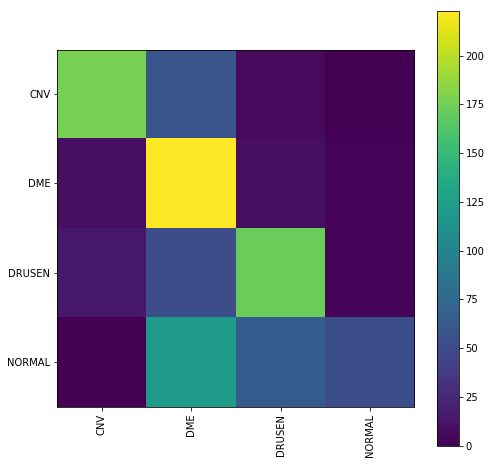

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(np.argmax(test_targets, axis=1), condition_predictions)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(['CNV','DME','DRUSEN','NORMAL']))
_ = plt.xticks(tick_marks, ['CNV','DME','DRUSEN','NORMAL'], rotation=90)
_ = plt.yticks(tick_marks, ['CNV','DME','DRUSEN','NORMAL'])

#  Transfer Learning- Fine Tuning and Image Augumentation

In [6]:
# Importing the VGG16 Model from keras applications

from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(150,150,3))
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

# We are freezing the firt 3 layers and fine-tue parameters for the other layers.

for layer in vgg_model.layers[:11]:
    layer.trainable = False

import pandas as pd
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 0us/step


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [8]:
# Buliding the Model using the vgg model and fine tune the parameters

from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,BatchNormalization,Activation
from keras.layers import Dropout,Flatten,Dense
from keras.models import Sequential

model = Sequential()

model.add(vgg_model)
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
_________________________________________________________________
batch_normalization_2 (Batch (None, 4)                 16        
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total para

In [10]:
#Complie the model

from keras import optimizers

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-5),metrics=['accuracy'])

In [13]:
from keras.callbacks import ModelCheckpoint  


checkpointer = ModelCheckpoint(filepath='weights.best.from_transfer.hdf5', verbose=1, save_best_only=True)

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=15,validation_data=val_generator, 
                              validation_steps=50,callbacks=[checkpointer],verbose=1)

Epoch 1/15
100/100 [==============================] - ETA: 15:14 - loss: 0.4247 - acc: 0.81 - ETA: 14:45 - loss: 0.3924 - acc: 0.83 - ETA: 14:30 - loss: 0.3764 - acc: 0.84 - ETA: 14:20 - loss: 0.3733 - acc: 0.85 - ETA: 14:10 - loss: 0.3566 - acc: 0.86 - ETA: 14:00 - loss: 0.3530 - acc: 0.85 - ETA: 13:52 - loss: 0.3532 - acc: 0.85 - ETA: 13:43 - loss: 0.3525 - acc: 0.85 - ETA: 13:35 - loss: 0.3498 - acc: 0.85 - ETA: 13:27 - loss: 0.3489 - acc: 0.85 - ETA: 13:17 - loss: 0.3469 - acc: 0.85 - ETA: 13:08 - loss: 0.3438 - acc: 0.85 - ETA: 13:01 - loss: 0.3427 - acc: 0.86 - ETA: 12:52 - loss: 0.3435 - acc: 0.86 - ETA: 12:44 - loss: 0.3516 - acc: 0.85 - ETA: 12:34 - loss: 0.3526 - acc: 0.85 - ETA: 12:25 - loss: 0.3480 - acc: 0.85 - ETA: 12:16 - loss: 0.3450 - acc: 0.85 - ETA: 12:06 - loss: 0.3422 - acc: 0.86 - ETA: 11:57 - loss: 0.3416 - acc: 0.86 - ETA: 11:48 - loss: 0.3407 - acc: 0.86 - ETA: 11:39 - loss: 0.3416 - acc: 0.86 - ETA: 11:30 - loss: 0.3394 - acc: 0.86 - ETA: 11:21 - loss: 0.3390 


Epoch 00002: val_loss improved from 0.16573 to 0.13257, saving model to weights.best.from_transfer.hdf5
Epoch 3/15
100/100 [==============================] - ETA: 14:40 - loss: 0.2432 - acc: 0.95 - ETA: 14:40 - loss: 0.2566 - acc: 0.93 - ETA: 14:32 - loss: 0.2747 - acc: 0.91 - ETA: 14:23 - loss: 0.2792 - acc: 0.90 - ETA: 14:12 - loss: 0.2809 - acc: 0.91 - ETA: 14:06 - loss: 0.2821 - acc: 0.90 - ETA: 14:00 - loss: 0.2828 - acc: 0.90 - ETA: 13:50 - loss: 0.2820 - acc: 0.90 - ETA: 13:41 - loss: 0.2827 - acc: 0.90 - ETA: 13:30 - loss: 0.2810 - acc: 0.90 - ETA: 13:21 - loss: 0.2787 - acc: 0.90 - ETA: 13:11 - loss: 0.2772 - acc: 0.90 - ETA: 13:02 - loss: 0.2775 - acc: 0.90 - ETA: 12:52 - loss: 0.2778 - acc: 0.90 - ETA: 12:43 - loss: 0.2793 - acc: 0.90 - ETA: 12:34 - loss: 0.2787 - acc: 0.90 - ETA: 12:25 - loss: 0.2775 - acc: 0.90 - ETA: 12:16 - loss: 0.2805 - acc: 0.90 - ETA: 12:06 - loss: 0.2786 - acc: 0.90 - ETA: 11:58 - loss: 0.2788 - acc: 0.90 - ETA: 11:49 - loss: 0.2835 - acc: 0.90 - E


Epoch 00005: val_loss did not improve from 0.13257
Epoch 6/15
100/100 [==============================] - ETA: 15:00 - loss: 0.2281 - acc: 0.94 - ETA: 14:45 - loss: 0.2378 - acc: 0.93 - ETA: 14:32 - loss: 0.2500 - acc: 0.93 - ETA: 14:23 - loss: 0.2460 - acc: 0.93 - ETA: 14:13 - loss: 0.2516 - acc: 0.93 - ETA: 14:04 - loss: 0.2448 - acc: 0.93 - ETA: 13:55 - loss: 0.2463 - acc: 0.93 - ETA: 13:47 - loss: 0.2488 - acc: 0.93 - ETA: 13:38 - loss: 0.2569 - acc: 0.92 - ETA: 13:29 - loss: 0.2536 - acc: 0.92 - ETA: 13:19 - loss: 0.2586 - acc: 0.92 - ETA: 13:10 - loss: 0.2568 - acc: 0.92 - ETA: 13:01 - loss: 0.2543 - acc: 0.92 - ETA: 12:52 - loss: 0.2556 - acc: 0.92 - ETA: 12:43 - loss: 0.2585 - acc: 0.92 - ETA: 12:33 - loss: 0.2583 - acc: 0.92 - ETA: 12:24 - loss: 0.2610 - acc: 0.92 - ETA: 12:15 - loss: 0.2611 - acc: 0.92 - ETA: 12:05 - loss: 0.2599 - acc: 0.92 - ETA: 11:56 - loss: 0.2590 - acc: 0.92 - ETA: 11:46 - loss: 0.2608 - acc: 0.92 - ETA: 11:37 - loss: 0.2621 - acc: 0.91 - ETA: 11:28 - l


Epoch 00008: val_loss improved from 0.13257 to 0.12856, saving model to weights.best.from_transfer.hdf5
Epoch 9/15
100/100 [==============================] - ETA: 15:24 - loss: 0.2839 - acc: 0.90 - ETA: 15:08 - loss: 0.2865 - acc: 0.91 - ETA: 14:56 - loss: 0.2774 - acc: 0.92 - ETA: 14:54 - loss: 0.2677 - acc: 0.92 - ETA: 14:45 - loss: 0.2715 - acc: 0.93 - ETA: 14:32 - loss: 0.2760 - acc: 0.92 - ETA: 14:18 - loss: 0.2733 - acc: 0.92 - ETA: 14:15 - loss: 0.2788 - acc: 0.91 - ETA: 14:04 - loss: 0.2753 - acc: 0.92 - ETA: 13:52 - loss: 0.2718 - acc: 0.92 - ETA: 13:43 - loss: 0.2716 - acc: 0.92 - ETA: 13:32 - loss: 0.2718 - acc: 0.92 - ETA: 13:22 - loss: 0.2722 - acc: 0.92 - ETA: 13:11 - loss: 0.2717 - acc: 0.92 - ETA: 13:01 - loss: 0.2715 - acc: 0.92 - ETA: 12:51 - loss: 0.2691 - acc: 0.92 - ETA: 12:41 - loss: 0.2701 - acc: 0.92 - ETA: 12:31 - loss: 0.2681 - acc: 0.92 - ETA: 12:21 - loss: 0.2645 - acc: 0.92 - ETA: 12:11 - loss: 0.2622 - acc: 0.92 - ETA: 12:01 - loss: 0.2630 - acc: 0.92 - E


Epoch 00011: val_loss improved from 0.12856 to 0.11377, saving model to weights.best.from_transfer.hdf5
Epoch 12/15
100/100 [==============================] - ETA: 14:47 - loss: 0.3345 - acc: 0.90 - ETA: 14:31 - loss: 0.3061 - acc: 0.90 - ETA: 14:22 - loss: 0.2897 - acc: 0.90 - ETA: 14:10 - loss: 0.2909 - acc: 0.90 - ETA: 14:01 - loss: 0.2791 - acc: 0.91 - ETA: 13:55 - loss: 0.2751 - acc: 0.91 - ETA: 13:49 - loss: 0.2746 - acc: 0.91 - ETA: 13:40 - loss: 0.2726 - acc: 0.91 - ETA: 13:30 - loss: 0.2679 - acc: 0.91 - ETA: 13:20 - loss: 0.2679 - acc: 0.92 - ETA: 13:11 - loss: 0.2648 - acc: 0.92 - ETA: 13:02 - loss: 0.2603 - acc: 0.92 - ETA: 12:53 - loss: 0.2574 - acc: 0.92 - ETA: 12:44 - loss: 0.2581 - acc: 0.92 - ETA: 12:35 - loss: 0.2612 - acc: 0.92 - ETA: 12:25 - loss: 0.2568 - acc: 0.92 - ETA: 12:17 - loss: 0.2540 - acc: 0.92 - ETA: 12:08 - loss: 0.2573 - acc: 0.92 - ETA: 12:00 - loss: 0.2587 - acc: 0.92 - ETA: 11:50 - loss: 0.2610 - acc: 0.92 - ETA: 11:41 - loss: 0.2598 - acc: 0.92 - 


Epoch 00014: val_loss did not improve from 0.10853
Epoch 15/15
100/100 [==============================] - ETA: 15:18 - loss: 0.2259 - acc: 0.94 - ETA: 15:06 - loss: 0.2297 - acc: 0.94 - ETA: 14:58 - loss: 0.2463 - acc: 0.93 - ETA: 14:48 - loss: 0.2417 - acc: 0.93 - ETA: 14:36 - loss: 0.2566 - acc: 0.92 - ETA: 14:21 - loss: 0.2600 - acc: 0.92 - ETA: 14:11 - loss: 0.2581 - acc: 0.92 - ETA: 14:00 - loss: 0.2612 - acc: 0.92 - ETA: 13:49 - loss: 0.2564 - acc: 0.92 - ETA: 13:39 - loss: 0.2605 - acc: 0.92 - ETA: 13:30 - loss: 0.2609 - acc: 0.92 - ETA: 13:20 - loss: 0.2564 - acc: 0.92 - ETA: 13:11 - loss: 0.2549 - acc: 0.93 - ETA: 13:01 - loss: 0.2526 - acc: 0.93 - ETA: 12:52 - loss: 0.2524 - acc: 0.93 - ETA: 12:41 - loss: 0.2519 - acc: 0.92 - ETA: 12:31 - loss: 0.2489 - acc: 0.93 - ETA: 12:22 - loss: 0.2489 - acc: 0.93 - ETA: 12:12 - loss: 0.2478 - acc: 0.93 - ETA: 12:03 - loss: 0.2463 - acc: 0.93 - ETA: 11:54 - loss: 0.2492 - acc: 0.93 - ETA: 11:44 - loss: 0.2495 - acc: 0.93 - ETA: 11:35 - 

In [14]:
model.load_weights('weights.best.from_transfer.hdf5')

In [17]:
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,auc,accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

condition_predictions_transfer = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
y_true = np.argmax(test_targets, axis=1)
y_probas_transfer = np.array(condition_predictions_transfer)

print('Test accuraccuracy_score for Transfer Learning Model: {}'.format(accuracy_score(y_true,y_probas_transfer)*100))

print('Confusion Matrix')
confusionmatrix_transfer = confusion_matrix(y_true,y_probas_transfer)
print(confusionmatrix_transfer)

print('Classification Report')
print(classification_report(y_true,y_probas_transfer, target_names=['CNV','DME','DRUSEN','NORMAL']))

Test accuraccuracy_score for Transfer Learning Model: 97.8305785123967
Confusion Matrix
[[241   1   0   0]
 [  1 235   0   6]
 [  9   2 229   2]
 [  0   0   0 242]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.96      1.00      0.98       242
         DME       0.99      0.97      0.98       242
      DRUSEN       1.00      0.95      0.97       242
      NORMAL       0.97      1.00      0.98       242

   micro avg       0.98      0.98      0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968



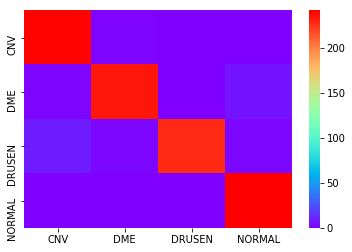

In [18]:
df_confusionmatrix = pd.DataFrame(confusionmatrix_transfer, index=['CNV','DME','DRUSEN','NORMAL'], columns=['CNV','DME','DRUSEN','NORMAL'])

sns.heatmap(df_confusionmatrix,cmap= 'rainbow')

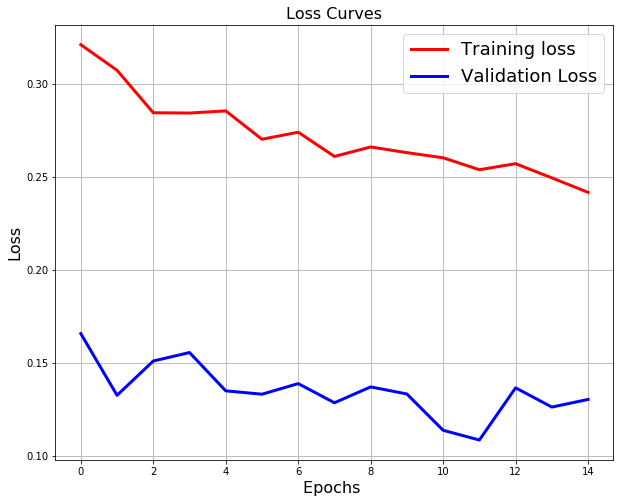

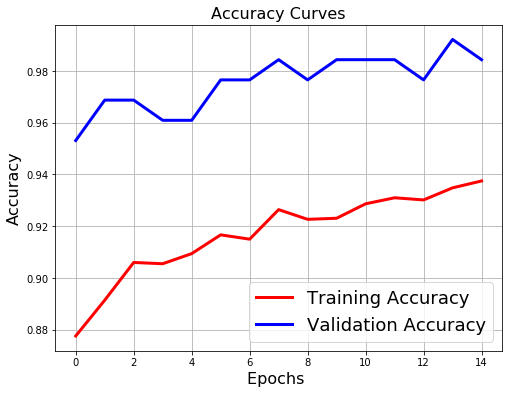

In [19]:
# Loss Curves
plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16);

# Predictions

In [47]:
#The model prediction for a given image path

from IPython.core.display import Image, display

def VGG16_predict_Condition(img_path):
    
    print('The given image path is {} and image is shown below'.format(img_path[8:]))
    display(Image(img_path,width=200,height=200))
    
    extract_feature = path_to_tensor(img_path)
    # obtain predicted vector
    predicted_vector = model.predict(extract_feature)
    # return condition that is predicted by the model
    print('The Predicted Condition is')
    return condition_names[np.argmax(predicted_vector)] [45:]

The given image path is NORMAL/NORMAL-4872585-1.JPEG and image is shown below


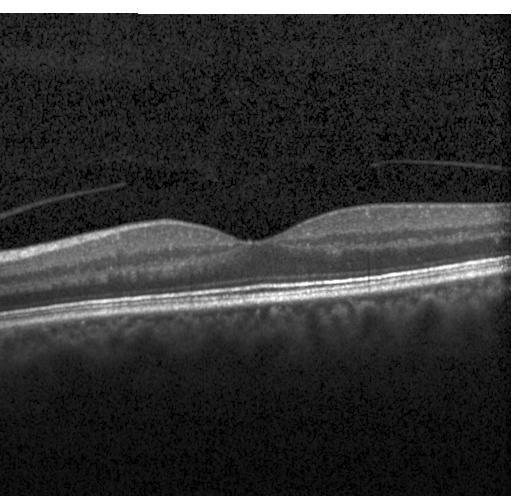

The Predicted Condition is


'NORMAL'

In [48]:
VGG16_predict_Condition('testing/NORMAL/NORMAL-4872585-1.JPEG')

The given image path is DME/DME-9583225-1.JPEG and image is shown below


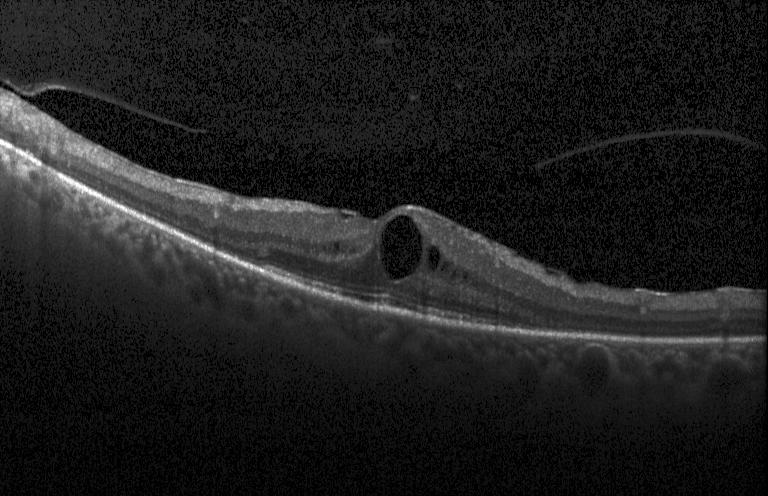

The Predicted Condition is


'DME'

In [49]:
VGG16_predict_Condition('testing/DME/DME-9583225-1.JPEG')

The given image path is CNV/CNV-6294785-1.JPEG and image is shown below


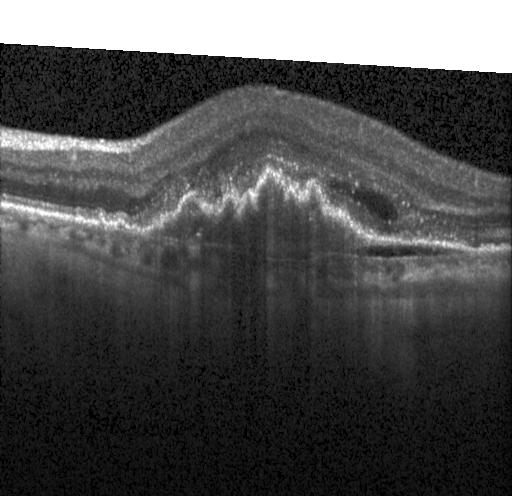

The Predicted Condition is


'CNV'

In [50]:
VGG16_predict_Condition('testing/CNV/CNV-6294785-1.JPEG')

The given image path is CNV/CNV-6652117-1.JPEG and image is shown below


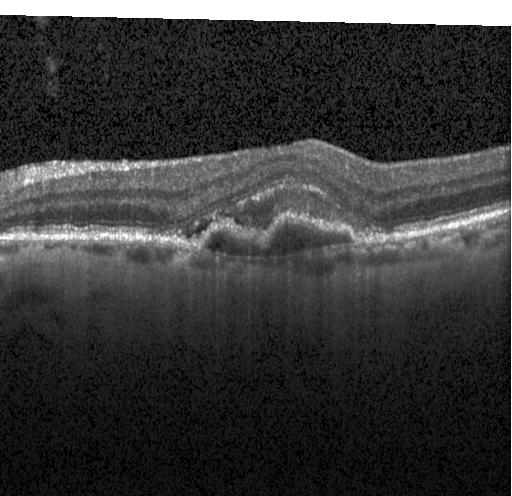

The Predicted Condition is


'CNV'

In [51]:
VGG16_predict_Condition('testing/CNV/CNV-6652117-1.JPEG')

The given image path is DRUSEN/DRUSEN-9837663-1.JPEG and image is shown below


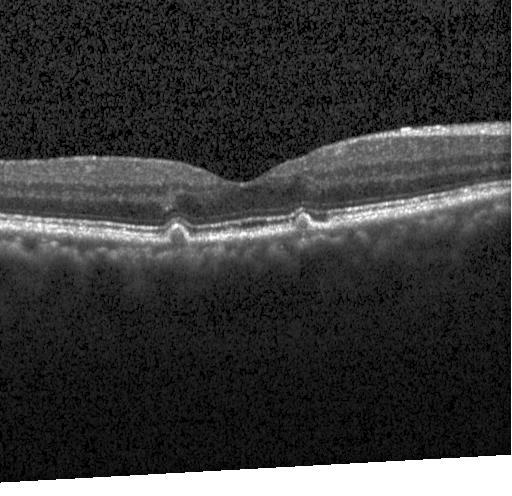

The Predicted Condition is


'DRUSEN'

In [52]:
VGG16_predict_Condition('testing/DRUSEN/DRUSEN-9837663-1.JPEG')